# Tutorial 4: Pipeline

## Overview

In this tutorial, we will talk about the following:

* [Loading data into a `Pipeline`](#t04Loading)
    * [Using tf.data.Dataset](#t04tf)
    * [Using torch.Dataloader](#t04torch)
    * [Using FastEstimator Datasets](#t04fe)
* [Getting results from a `Pipeline`](#t04results)
* [How to use Numpy Operators in a `Pipeline`](#t04numpy)
    * [Univariate Numpy Operators](#t04univariate)
    * [Multivariate Numpy Operators](#t04multivariate)
    * [Customized Numpy Operators](#t04custom)
    * [Visualizing `Pipeline` Output](#t04vis)
* [Related Apphub Examples](#t04apphub)

In deep learning, data preprocessing is a way of converting data from its raw form to a more usable or desired representation. It is one crucial step in model training as it directly impacts the ability of model to learn. In FastEstimator, the `Pipeline` API enables such preprocessing tasks in an efficient manner. The `Pipeline` manages everything from  extracting data from the disk up until it is fed into the model. `Pipeline` operations usually happen on the CPU.

<a id='t04Loading'></a>

## Loading data into a Pipeline

In [Tutorial 2](./t02_dataset.ipynb) we demonstrated different ways to construct FastEstimator datasets. Here we will see how datasets can be loaded in the `Pipeline` and how various operations can then be applied to the data. `fe.Pipeline` handles three different types of datasets:

* tf.data.Dataset
* torch.data.Dataloader
* fe.dataset

Let's create an example `tf.data.Dataset` and `torch.data.Dataloader` from numpy arrays and we will load them into a `Pipeline`:

In [1]:
import numpy as np

# Make some random data to serve as the source for our datasets
x_train, y_train = (np.random.sample((100, 2)), np.random.sample((100, 1)))
train_data = {"x": x_train, "y": y_train}

<a id='t04tf'></a>

### Using tf.data.Dataset

In [2]:
import fastestimator as fe
import tensorflow as tf

# Create a tf.data.Dataset from sample data
dataset_tf = tf.data.Dataset.from_tensor_slices(train_data)
dataset_tf = dataset_tf.batch(4)

# Load data into the pipeline
pipeline_tf = fe.Pipeline(dataset_tf)

<a id='t04torch'></a>

### Using torch.data.Dataloader

We will create a custom dataset class to load our train data into a PyTorch DataLoader.

In [3]:
from torch.utils.data import Dataset

class TorchCustomDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    def __len__(self):
        return self.data["x"].shape[0]
    def __getitem__(self, idx):
        return {key: self.data[key][idx] for key in self.data}

In [4]:
import torch
from torch.utils import data

# Create a torch.data.Dataloader from sample data
dataset_torch = TorchCustomDataset(train_data)
dataloader_torch = data.DataLoader(dataset_torch, batch_size=4)

# Load data into the pipeline
pipeline_torch = fe.Pipeline(dataloader_torch)

<a id='t04fe'></a>

### Using a FastEstimator Dataset

Next, we will see how to use one of the Fastestimator Datasets in the `Pipeline`. We will create `fe.dataset.NumpyDataset` and load it into our pipeline. As we saw in [Tutorial 2](./t02_dataset.ipynb), `NumpyDataset` takes a dictionary with keys for the <b>input data</b> and <b>ground truth labels</b>.

In [5]:
from fastestimator.dataset.numpy_dataset import NumpyDataset

# Create a NumpyDataset from the sample data
dataset_fe = NumpyDataset(train_data)

pipeline_fe = fe.Pipeline(train_data=dataset_fe, batch_size=1)

<a id='t04results'></a>

## Getting results from a Pipeline

After loading the data or performing preprocessing tasks, you might want to inspect the data in the `Pipeline` and ensure the output of the `Pipeline` is as you expected. `fe.Pipeline.get_results` provides this feature:

In [6]:
pipeline_tf.get_results(num_steps=1)

{'x': <tf.Tensor: shape=(4, 2), dtype=float64, numpy=
 array([[0.75018338, 0.96604765],
        [0.08914385, 0.66352997],
        [0.66633148, 0.01311595],
        [0.27073451, 0.22176897]])>,
 'y': <tf.Tensor: shape=(4, 1), dtype=float64, numpy=
 array([[0.30493647],
        [0.73671124],
        [0.0560095 ],
        [0.14244441]])>}

<a id='t04numpy'></a>

## Using Numpy Operators in Pipeline

In [Tutorial 3](./t03_operator.ipynb), we learned about `Operators` and their structure. They are used in FastEstimator for constructing workflow graphs. Here we will talk specifically about Numpy Operators (`NumpyOp`s) and how to use them in `Pipeline`.

`NumpyOp`s form the foundation of FastEstimator data augmentation within the `Pipeline`, and inherit from the `Op` base class. They perform preprocessing and augmentation tasks on non-Tensor data. With a list of `NumpyOp`s, even complicated preprocessing tasks can be implemented in only a few lines of code. Many of the augmentation operations in FastEstimator leverage the image augmentation library [albumentations](https://github.com/albumentations-team/albumentations).

`NumpyOp` can be further subdivided into three main categories:
   * Univariate `NumpyOp`s
   * Multivariate `NumpyOp`s
   * Meta `NumpyOp`s
   
In addition to the pre-built offerings, we can customize the `NumpyOp` to perform our own operations on the data. By inheriting `fe.op.numpyop` we can create custom `NumpyOp`s and use them in our `Pipeline`. In this tutorial, we will learn about Univariate, Multivariate and Custom Numpy Operators. We will discuss Meta NumpyOp's an [advanced tutorial](../advanced/t03_operator.ipynb).

To demonstrate use of operators, we will first load the Fashion MNIST dataset in our Pipeline and then will define list of Numpy Operators for preprocessing data. We will then visualize the `Pipeline`s inputs and outputs.

In [7]:
from fastestimator.dataset.data import mnist

mnist_train, mnist_eval = mnist.load_data()

<a id='t04univariate'></a>

### Univariate NumpyOp

Univariate Numpy Operators perform the same operation for all input features. They take one or more input(s) and return an equal number of outputs, applying the same transformation to each input/output pair. For example, `Minmax` is an univariate Numpy Operator. No matter what feature it is given, it will perform:

data = (data - min) / (max - min)

In [8]:
from fastestimator.op.numpyop.univariate import Minmax

minmax_op = Minmax(inputs="x", outputs="x_out")

<a id='t04multivariate'></a>

### Multivariate NumpyOp

Multivariate Numpy Operators perform different operations based on the nature of the input features. For example, if you have an image with an associated mask as well as bounding boxes, rotating all three of these objects together requires the backend code to know which of the inputs is an image and which is a bounding box. Here we will demonstrate the `Rotate` Numpy Operator which will rotate images randomly by some angle in the range (-60, 60) degrees.

In [9]:
from fastestimator.op.numpyop.multivariate import Rotate

rotation_op = Rotate(image_in="x_out", image_out="x_out", limit=60)

<a id='t04custom'></a>

### Custom NumpyOp

Let's create custom Numpy Operator that adds random noise to the input images.

In [10]:
from fastestimator.op.numpyop import NumpyOp

class AddRandomNoise(NumpyOp):
    def forward(self, data, state):
        # generate noise array with 0 mean and 0.1 standard deviation
        noise = np.random.normal(0, 0.1, data.shape)
        data = data + noise
        return data
    
random_noise_op = AddRandomNoise(inputs="x_out", outputs="x_out")

<a id='t04vis'></a>

### Visualizing Pipeline Outputs

Now, let's add our `NumpyOp`s into the `Pipeline` and visualize the results. 

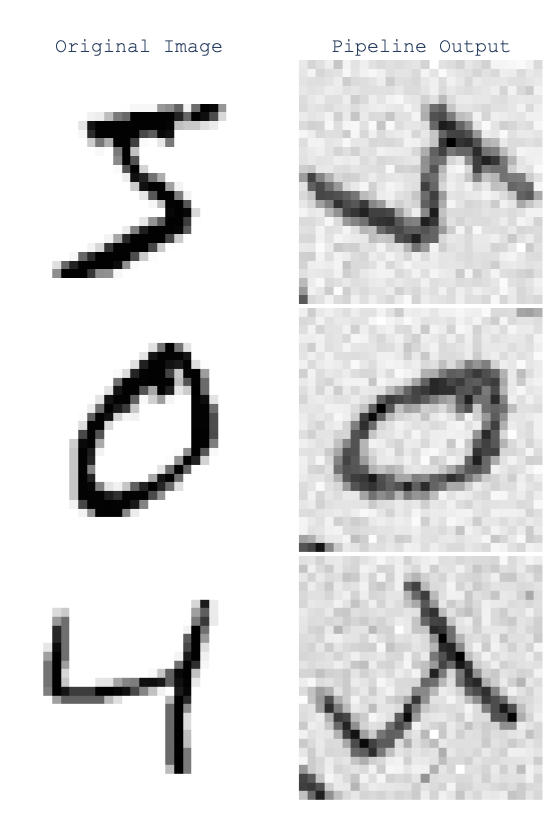

In [11]:
from fastestimator.util import BatchDisplay, GridDisplay

pipeline = fe.Pipeline(train_data=mnist_train,
                       eval_data=mnist_eval,
                       ops=[minmax_op, rotation_op, random_noise_op],
                       batch_size=3)

data = pipeline.get_results()
img = GridDisplay([BatchDisplay(image=data["x"], title="Original Image"), BatchDisplay(image=data["x_out"], title="Pipeline Output")])
img.show()

<a id='t04apphub'></a>

## Apphub Examples
You can find some practical examples of the concepts described here in the following FastEstimator Apphubs:

* [CIFAR10](../../apphub/image_classification/cifar10_fast/cifar10_fast.ipynb)
* [Bert](../../apphub/NLP/named_entity_recognition/bert.ipynb)
* [FGSM](../../apphub/adversarial_training/fgsm/fgsm.ipynb)